In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import utils
from functools import partial
from utils import KernelFunction, KernelEnvironment
from utils import plot_kernel_function, compare_kernels
from gflownet import GFlowNet 

In [2]:
import torch.nn.functional as F
from torch.distributions import Categorical
import torch

In [3]:
from utils import ForwardPolicy, BackwardPolicy
import random

In [4]:
def set_seed(seed):
    """
    Sets the seed for reproducibility.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # For all GPUs
    np.random.seed(seed)
    random.seed(seed)
    
    # These two lines are for full reproducibility with CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# --- Call this at the start of your script ---
set_seed(42)

In [5]:
global reward_calls
reward_calls = 0
def log_likelihood_reward(X, Y, env: 'KernelEnvironment'):
    """
    Computes the log marginal likelihood of each kernel in the environment
    given the data (X, Y).
    """
    global reward_calls
    reward_calls += env.batch_size
    rewards = []
    for k in env.state: 
        log_likelihood = utils.evaluate_likelihood(k, X, Y)
        #print(np.log(1 + np.exp(-0.5 * (log_likelihood - 5))))
        reward = 1 / np.log(1 + np.exp(-0.05 * (log_likelihood))) 
        if reward < 1e-10:
            print("Warning: Reward is too small, setting to 1e-10")
            reward = 1e-10
        rewards.append(reward if log_likelihood is not None else 1e-10)
        #print(reward, log_likelihood)
        #rewards.append(log_likelihood**(3/2) if log_likelihood is not None else 1e-10)
    return torch.tensor(rewards, dtype=torch.float32) 

def create_env(batch_size=64):
    return KernelEnvironment(
    batch_size=batch_size,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

def create_env(batch_size=64):
    return KernelEnvironment(
    batch_size=batch_size,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

In [6]:
def randomize_hyperparameters(kernel: KernelFunction):
    """
    Recursively traverses a KernelFunction object and randomly modifies the
    hyperparameters of its base components in a reasonable range.
    
    Args:
        kernel (KernelFunction): The kernel object to modify in-place.
    """
    # Base case: If this is a base kernel (like RBF, Linear), modify its params.
    # A base kernel has no children.
    if not kernel.children:
        if kernel.hyperparams:
            print(f"  -> Randomizing '{kernel.name}' params...")
            for param, value in kernel.hyperparams.items():
                # Define a scaling factor to adjust the parameter.
                # e.g., random.uniform(0.5, 1.5) will change the value
                # by -50% to +50% of its original value.
                scale_factor = random.uniform(0.5, 1.5)
                new_value = value * scale_factor
                
                # Update the hyperparameter in the dictionary, rounding for neatness
                kernel.hyperparams[param] = round(new_value, 3)

    # Recursive step: If this is a composite kernel (Sum, Product),
    # call this function on each of its children.
    else:
        for child in kernel.children:
            randomize_hyperparameters(child)

def create_random_kernel():
    """
    Creates a random kernel function.
    """
    # Create a series of actions from a uniform distribution
    env = KernelEnvironment(
        batch_size=1,
        max_trajectory_length=4,
        log_reward=log_likelihood_reward
    )
    n = env.action_space_size  
    logits = torch.ones(n) 
   

    for i in range(4):
        if i == 0:
            #prevent the first action from being a stop (-1)
            logits[-1] = -torch.inf
            dist = Categorical(logits=logits)
            actions = dist.sample((1,))  # Creates a 1D tensor of shape [1]
        else:
            logits[-1] = 1
            dist = Categorical(logits=logits)
            actions = dist.sample((1,)) # Creates a 1D tensor of shape [1]

        env.apply(actions)
    
    KFn = env.state[0]
    randomize_hyperparameters(KFn)
    
    return KFn


  -> Randomizing 'Constant' params...
  -> Randomizing 'Constant' params...
  -> Randomizing 'Periodic' params...
True Kernel: ((Constant({'variance': 1.139}) * Constant({'variance': 0.525})) * Periodic({'period': 0.775, 'variance': 0.723, 'lengthscale': 1.236})) Log Marginal Likelihood: 77.55666898311783


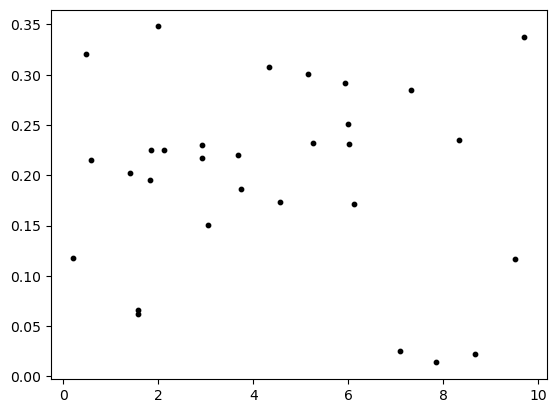

In [7]:
ll = -1
while ll < 0:
    true_kernel = create_random_kernel()
    X, Y, true_kernel_str = utils.generate_gp_data(true_kernel, input_dim=1, n_points=30, noise_var=1e-4)
    X_test, Y_test, _ = utils.generate_gp_data(true_kernel, input_dim=1, n_points=50, noise_var=1e-4)
    ll = utils.evaluate_likelihood(true_kernel, X, Y, runtime=False)

print("True Kernel:", true_kernel_str, "Log Marginal Likelihood:", utils.evaluate_likelihood(true_kernel, X, Y, runtime=False))

plt.scatter(X, Y, color='black', s=10, label='Data Points')

In [8]:
candidate_kernel = create_random_kernel()
print("True Kernel:", candidate_kernel, "Log Marginal Likelihood:", utils.evaluate_likelihood(candidate_kernel, X, Y, runtime=False))

  -> Randomizing 'Linear' params...
  -> Randomizing 'Constant' params...
  -> Randomizing 'Periodic' params...
True Kernel: ((Linear({'variances': 1.177}) * Constant({'variance': 1.392})) * Periodic({'period': 0.587, 'variance': 0.922, 'lengthscale': 0.53})) Log Marginal Likelihood: 17.607937853316905


In [15]:
from utils import train

epochs = 100
BATCH_SIZE = 256
MAX_LEN = 4
lr = 1e-3

log_reward_fn = partial(log_likelihood_reward, X, Y)
env = create_env()

forward_model = ForwardPolicy(input_dim=MAX_LEN, output_dim=env.action_space_size, epsilon=0.5)
backward_model = BackwardPolicy()
criterion = 'db'

In [13]:
4 * env.action_space_size ** (5 -1)

26244

In [ ]:
gflownet = GFlowNet(
    forward_flow=forward_model, 
    backward_flow=backward_model, 
    criterion=criterion 
)


gflownet, losses = train(
    gflownet=gflownet,
    create_env=create_env,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    lr=lr,
    min_eps=1e-2,
    clamp_g= 1,
    use_scheduler=True
)

  0%|          | 0/100 [00:00<?, ?it/s] /home/guilherme/miniconda3/envs/gpy_env/lib/python3.11/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/guilherme/miniconda3/envs/gpy_env/lib/python3.11/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/guilherme/miniconda3/envs/gpy_env/lib/python3.11/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply
  2%|▏         | 2/100 [00:38<29:07, 17.83s/it, loss=194]

In [ ]:
# --- Sampling from the Trained GFlowNet ---
print("\n Sampling 25 kernels from the trained model...")
eval_env = KernelEnvironment(
    batch_size=25,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

gflownet.eval()
final_batch_ll = gflownet.sample(eval_env)

# Expect to see kernels with high log likelihood
for i, kernel in enumerate(final_batch_ll.state):
    print(f"Sample {i+1}: {kernel}, Reward: {1 / np.log(1 + np.exp(-0.05 * (utils.evaluate_likelihood(kernel, X, Y))))}, Log Likelihood: {utils.evaluate_likelihood(kernel, X_test, Y_test):.4f}")


 Sampling 25 kernels from the trained model...
Sample 1: RBF({'lengthscale': 1.0, 'variance': 1.0}), Reward: 2.8560823960795, Log Likelihood: 17.3857
Sample 2: RBF({'lengthscale': 1.0, 'variance': 1.0}), Reward: 2.8560823960795, Log Likelihood: 17.3857
Sample 3: RBF({'lengthscale': 1.0, 'variance': 1.0}), Reward: 2.8560823960795, Log Likelihood: 17.3857
Sample 4: RBF({'lengthscale': 1.0, 'variance': 1.0}), Reward: 2.8560823960795, Log Likelihood: 17.3857
Sample 5: RBF({'lengthscale': 1.0, 'variance': 1.0}), Reward: 2.8560823960795, Log Likelihood: 17.3857
Sample 6: (((Linear({'variances': 1.0}) + RBF({'lengthscale': 1.0, 'variance': 1.0})) + RBF({'lengthscale': 1.0, 'variance': 1.0})) * RBF({'lengthscale': 1.0, 'variance': 1.0})), Reward: 2.0635321568167537, Log Likelihood: 9.4470
Sample 7: RBF({'lengthscale': 1.0, 'variance': 1.0}), Reward: 2.8560823960795, Log Likelihood: 17.3857
Sample 8: RBF({'lengthscale': 1.0, 'variance': 1.0}), Reward: 2.8560823960795, Log Likelihood: 17.3857
S

In [ ]:
eval_env = KernelEnvironment(
    batch_size=1000,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

gflownet.eval()
final_batch_ll = gflownet.sample(eval_env)


#Count different kernels AKA numbeer of modes
kernel_counts = {}
for kernel in final_batch_ll.state:
    #only add the kernel if it is not already in the dictionary
    kernel_str = str(kernel)
    if kernel_str not in kernel_counts:
        kernel_counts[kernel_str] = 1
    else:
        kernel_counts[kernel_str] += 1

print(f"Total number of unique kernels sampled: {len(kernel_counts)}")



Total number of unique kernels sampled: 76


In [ ]:
from collections import defaultdict
@torch.no_grad()
def calculate_l1_distance(forward_policy: ForwardPolicy, env_class: KernelEnvironment, max_len: int, X, Y):
    """
    Computes the L1 distance between the policy distribution and the target reward distribution.

    Args:
        forward_policy (ForwardPolicy): The trained forward policy model.
        env_class (KernelEnvironment): The environment class (not an instance).
        max_len (int): The maximum trajectory length.
        X, Y: Data for computing the reward.

    Returns:
        float: The L1 distance.
    """
    # This dictionary will store data for each unique terminal kernel.
    # Key: string representation of the kernel
    # Value: {'reward': float, 'policy_prob': float}
    terminal_states_data = defaultdict(lambda: {'reward': 0.0, 'policy_prob': 0.0})

    # We need a dummy env to get action space info
    dummy_env = env_class(batch_size=1, max_trajectory_length=max_len, log_reward=None)
    action_map = dummy_env.action_map
    end_action_id = dummy_env.end_action_id

    def _enumerate_and_calc_probs(env: KernelEnvironment, current_log_prob: float):
        """A recursive helper to explore all trajectories."""
        # Check if the current path has reached max length
        if len(env.history[0]) >= max_len:
            # This path is forced to terminate. Treat it as a terminal state.
            kernel_str = str(env.state[0])
            if terminal_states_data[kernel_str]['reward'] == 0.0:
                 reward = log_likelihood_reward(X, Y, env).item()
                 terminal_states_data[kernel_str]['reward'] = reward
            
            # Add the probability of this path to the kernel's total probability
            terminal_states_data[kernel_str]['policy_prob'] += torch.exp(torch.tensor(current_log_prob)).item()
            return

        # Explore all valid actions from the current state
        # The `forward` method gives us logits for all actions
        _, _, all_logits, _ = forward_policy.net(env)   
        
        # Ensure we have a clean probability distribution over valid actions
        dist = Categorical(logits=all_logits)

        for action_id, (op, k_name) in action_map.items():
            # Check if action is valid for the current state using the mask
            if not env.mask[0, action_id]:
                continue
            
            # Calculate the log probability of taking this action
            action_log_prob = dist.log_prob(torch.tensor(action_id)).item()
            new_total_log_prob = current_log_prob + action_log_prob

            # If it's the 'end' action, it's a terminal state
            if action_id == end_action_id:
                kernel_str = str(env.state[0])
                if terminal_states_data[kernel_str]['reward'] == 0.0:
                    reward = log_likelihood_reward(X, Y, env).item()
                    terminal_states_data[kernel_str]['reward'] = reward
                
                terminal_states_data[kernel_str]['policy_prob'] += torch.exp(torch.tensor(new_total_log_prob)).item()
            else:
                # If not 'end', take a step and recurse
                # Create a copy of the environment state to explore this branch
                next_env = deepcopy(env)
                next_env.apply(torch.tensor([action_id]))
                _enumerate_and_calc_probs(next_env, new_total_log_prob)

    # To use the above function, you'll need to slightly modify your ForwardPolicy
    # to return the raw logits for all actions, not just the sampled one.
    # Let's assume a modified forward function like this:
    # def forward(self, batch_state, actions=None):
    #     ...
    #     # After applying mask
    #     return actions, log_probs.squeeze(), logits, state_flow.squeeze()
    
    # Start the recursion from the initial state
    initial_env = env_class(batch_size=1, max_trajectory_length=max_len, log_reward=None)
    _enumerate_and_calc_probs(initial_env, 0.0) # Start with log_prob = 0 (i.e., prob = 1)

    # --- Post-processing ---
    
    # 1. Extract rewards and policy probabilities
    rewards = np.array([data['reward'] for data in terminal_states_data.values()])
    policy_probs = np.array([data['policy_prob'] for data in terminal_states_data.values()])

    # 2. Calculate the Target Distribution P_T
    partition_Z = np.sum(rewards)
    if partition_Z == 0: return np.sum(policy_probs) # Should not happen if rewards are > 0
    target_dist = rewards / partition_Z

    # 3. Normalize the Policy Distribution P_theta
    # The sum of policy_probs should be close to 1.0 if all paths are explored.
    # Normalizing handles any minor floating point errors or unexplored paths.
    policy_dist_sum = np.sum(policy_probs)
    if policy_dist_sum == 0: return np.sum(target_dist) # No paths found
    policy_dist = policy_probs / policy_dist_sum

    # 4. Compute L1 Distance
    l1_distance = np.sum(np.abs(target_dist - policy_dist))
    
    return l1_distance

In [ ]:
l1 = calculate_l1_distance(gflownet.forward_flow , KernelEnvironment, 4, X, Y)

In [ ]:
print(f"Total reward calls: {len(utils._likelihood_cache)}")
#utils._likelihood_cache = {}  # Clear the cache after sampling

Total reward calls: 2300
